### Importing all libraries

In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import warnings
import librosa
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook
from IPython.display import Audio

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame(),limit: int=3)->(list,dict):
    s=sorted(df[1].unique())
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<limit]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Data Augmentation

In [3]:
def add_noise(data,alpha=0.015):
    noise_value = alpha * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    

    return output_result


def extract_features(file_name):
    
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

### Dataset Class

In [4]:
class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_file_path=None,
                 audio_files=None,
                 audio_files_labels=None,
                 header=None,
                 transform=False) -> None:
        
        self.paths=[]
        self.audio_files=[]
        self.y=[]
        
        if (audio_path==None and audio_file_path==None and audio_files==None):
            raise Exception("audio_path, audio_file_path and audio_files cannot be None at the same time")

        if(audio_file_path==None and audio_files==None):
            audio_fetch(audio_path,self.paths)
        elif(audio_file_path!=None and audio_files==None):
            self.paths=audio_file_path
        else:
            self.audio_files=audio_files
            self.y=audio_files_labels
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df,limit=10)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

        self.scaler=StandardScaler()
        self.transform=transform
    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]

    def get_all_class_idx(self) -> list:
        l=[]
        for i in range(len(self.paths)):
            l.append(self.class_to_idx[self.info_df[self.info_df[0]==int(self.paths[i].split("/")[-1].split("_")[0])][1].values[0]])
        return l
    

    
    def apply_transform(self,x,sr):
        n=torch.randint(low=0,high=2,size=(1,))
        x=add_noise(x,0.015*n.item())
        x=stretch_process(x,0.8*n.item())
        x=pitch_process(x,sr,0.7*n.item())
        return x
    
    def __len__(self) -> int:
        if(len(self.audio_files)==0):
            return len(self.paths)
        else:
            return len(self.y)


    def __getitem__(self, index: int) -> torch.Tensor():
        if(len(self.audio_files)==0):
            self.val=self.paths[index]
            self.class_val=self.class_to_idx[self.get_class(self.val)]
    
            self.signal, self.sr = librosa.load(self.val)
            if(self.transform!=False):
                self.signal=self.apply_transform(self.signal,self.sr)
                
            self.signal = torch.unsqueeze(torch.from_numpy(np.squeeze(self.scaler.fit_transform(np.reshape(extract_process(self.signal, self.sr),newshape=(-1,1))))),dim=0).type(torch.float32)
            
            return self.signal,self.class_val
            
        else:
            return torch.unsqueeze(torch.tensor(self.audio_files[index]),dim=0).type(torch.float32),self.class_to_idx[self.y[index]]

##### Testing audio dataset

In [5]:
ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
ds.class_to_idx

{'COPD': 0, 'Healthy': 1, 'URTI': 2}

In [6]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

104
COPD


### Dataloader

In [27]:
BATCH_SIZE=32
SPLIT=0.2
ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=SPLIT,shuffle=True)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.0001,shuffle=True)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")


train_ds=audio_dataset(audio_file_path=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transform=True)
test_ds=audio_dataset(audio_file_path=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transform=True)
val_ds=audio_dataset(audio_file_path=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")


key=int(input("\nDo you want to augment data (0 or 1): "))

if(key):
    features = []
    labels = []
    info_df=pd.read_csv("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)
    
    # Iterate through each sound file and extract the features
    for file_name in train_ds.paths:
        data = extract_features(file_name)
        label=info_df[info_df[0]==int(file_name.split("/")[-1].split("_")[0])][1].values[0]
        labels.append(label)
        features.append(data)
            
    print('\nFinished feature extraction from ', len(features), ' files')
    features = np.array(features)
    labels=np.array(labels)
    
    augmented_features = np.reshape(features, (-1, 182))
    augmented_labels = np.repeat(labels, 3)
    
    train_ds.audio_files=augmented_features
    train_ds.y=augmented_labels

    print(f"\nAfter augmentaion:")
    print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

try:
    def get_class_weight_sampler(ds: audio_dataset) -> torch.Tensor():
        y=[]
        try:
            for i in range(ds.__len__()):
                y.append(ds.get_class(ds.paths[i]))
            class_weights = dict(1/pd.Series(y).value_counts())
        except Exception as e:
            class_weights = dict(1/pd.Series(ds.y).value_counts())
    
        wt=[]
        for i in ds.classes:
            wt.append(class_weights[i])
        weight=[wt[i] for i in ds.get_all_class_idx()]
        
        return weight

    weights=get_class_weight_sampler(train_ds)
    sampler_train=torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=train_ds.__len__(), replacement=True)

    weights=get_class_weight_sampler(test_ds)
    sampler_test=torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=test_ds.__len__(), replacement=True)
  
    train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,sampler=sampler_train)
    test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
    val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

    print(f"\nData loaded with oversampling")

except Exception as e:
    print(f"\n{e}\n")
    train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
    test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
    val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)
    print(f"\nData loaded without oversampling")

Before trimming:
No. of audio files in train_ds: 736
No. of audio files in test_ds: 183
No. of audio files in val_ds: 1

After trimming:
No. of audio files in train_ds: 682
No. of audio files in test_ds: 168
No. of audio files in val_ds: 1



Do you want to augment data (0 or 1):  0



Data loaded with oversampling


### Class imbalance check

In [28]:
def show_imbalance(dl: torch.utils.data.DataLoader, batches: int, train_ds: torch.utils.data.Dataset):
    for i in range(batches):
        data, label=next(iter(dl))
        data_qty={i:0 for i in range(len(train_ds.classes))}
        for i in label:
            data_qty[i.item()]+=1
        print(data_qty)

In [29]:
show_imbalance(train_loader,2,train_ds)

{0: 9, 1: 9, 2: 14}
{0: 10, 1: 9, 2: 13}


##### Checking dataloader

In [10]:
im=next(iter(train_loader))[0]
im.shape

torch.Size([32, 1, 182])

In [11]:
im[0].dtype

torch.float32

In [15]:
assert ((train_ds.classes==test_ds.classes and test_ds.classes==val_ds.classes))
train_ds.classes==test_ds.classes and test_ds.classes==val_ds.classes

True

### Setting up Tensorboard and performance metrics

In [16]:
log_dir = "../"+"performance"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

f1_fn=MulticlassF1Score(num_classes=len(train_ds.classes)).to(device)
cf_matrix=ConfusionMatrix(num_classes=len(train_ds.classes),task="multiclass")

### Model 1 (Simple Conv1D Network)

In [17]:
class auditory_conv1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.Conv1d(in_channels=1,out_channels=256,stride=1,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=256,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=1,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Dropout(p=0.2),
                                           nn.Flatten(),
                                           nn.ReLU(),
                                           nn.Linear(in_features=192,out_features=32,bias=True),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(in_features=32,out_features=len(train_ds.classes),bias=True))

    def forward(self,x):
        return self.input_embedding(x)

### Model 2 (LSTM)

In [18]:
class auditory_lstm(nn.Module):
    def __init__(self,input_size=182,hidden_size=32,num_layers=2,output=6):
        super().__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output=output
        self.lstm1=nn.LSTM(self.input_size,self.hidden_size,self.num_layers, batch_first=True)
        self.lstm_dropout=nn.Dropout(p=0.3)
        self.classifcation_head=nn.Sequential(nn.Linear(in_features=64,out_features=128,bias=True),
                                              nn.ReLU(),
                                              nn.BatchNorm1d(num_features=128),
                                              nn.Dropout(p=0.4),
                                              nn.Linear(in_features=128,out_features=128,bias=True),
                                              nn.ReLU(),
                                              nn.BatchNorm1d(num_features=128),
                                              nn.Dropout(p=0.3),
                                              nn.Linear(in_features=128,out_features=64,bias=True),
                                              nn.ReLU(),
                                              nn.Dropout(p=0.2),
                                              nn.Linear(in_features=64,out_features=self.output,bias=True))
        
    def forward(self, x):
        self.output, (_x,_y)=self.lstm1(x)
        self.output=self.classifcation_head(torch.squeeze(self.lstm_dropout(self.output)))
        return torch.squeeze(self.output)


class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        # Use output of the last time step for classification
        out = self.fc(out[:, -1, :])
        return out

#### Model testing and training

In [21]:
input_size = 182  # Input size, for example, if using a spectrogram
hidden_size = 64
num_layers = 2
num_classes = 3  # Number of classes for classification

model1=auditory_conv1d().to(device)
#model2 = AudioLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
#model2=auditory_lstm().to(device)

test=next(iter(train_loader))[0].to(device)

with torch.inference_mode():
    print(model1(test).shape)
    #print(model2(test).shape)

torch.Size([32, 3])


#### Training Function

In [22]:
def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        test_preds=torch.tensor([])
        train_actual=torch.tensor([])
        test_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and test data
        temp_train_accuracy=[]
        temp_test_accuracy=[]
        temp_train_loss=[]
        temp_test_loss=[]
        temp_train_f1=[]
        temp_test_f1=[]
    
        net_train_accuracy=0
        net_test_accuracy=0
        net_train_loss=0
        net_test_loss=0
        net_train_f1=0
        net_test_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits.squeeze(),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(test_loader)) as pbar2:
            for x,y in test_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    test_preds=torch.hstack((test_preds,preds.to("cpu")))
                    test_actual=torch.hstack((test_actual,y.to("cpu")))
                    accuracy_test=accuracy_fn(logits,y)
                    f1_test=f1_fn(preds,y)
                    temp_test_accuracy.append(accuracy_test)
                    temp_test_loss.append(loss.item())
                    temp_test_f1.append(f1_test.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
        net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
        net_test_f1=sum(temp_test_f1)/len(temp_test_f1)
        writer.add_scalar("Test Accuracy",net_test_accuracy,i)
        writer.add_scalar("Test Loss",net_test_loss,i)
        writer.add_scalar("Test F1 Score",net_test_f1,i)

        '''
        #Saving the model
        try:
            os.makedirs(f"./{model_name}_feature_extractor/")
        except Exception as e:
            pass
        torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
        '''
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Test confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()

### Training Model 1

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.5289772727272727

Train Loss: 0.9143013954162598

Train F1 Score: 0.5126435336741534

Test Accuracy: 0.5989583333333334

Test Loss: 0.7462676266829172

Test F1 Score: 0.28901977588733035




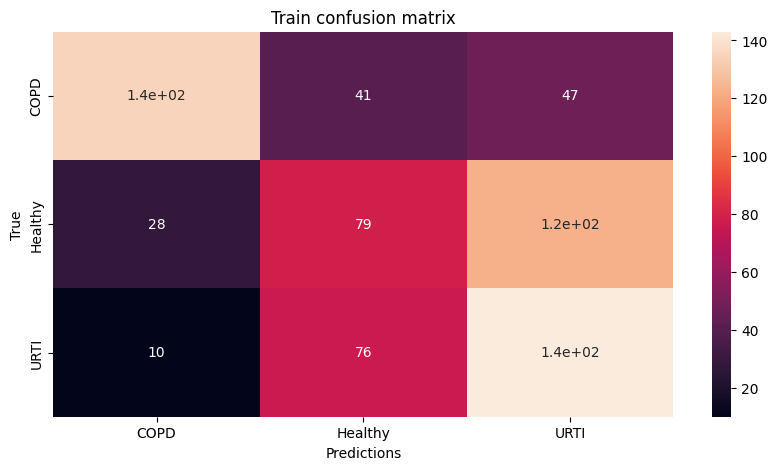

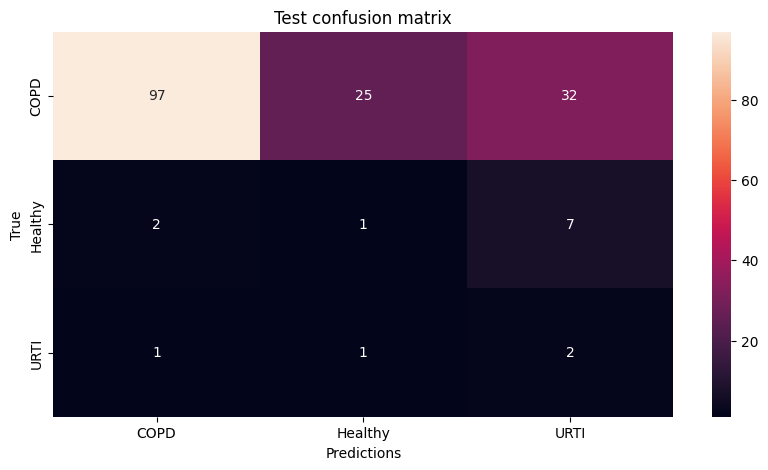


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.4943181818181818

Train Loss: 0.9320584075017408

Train F1 Score: 0.4802373011003841

Test Accuracy: 0.671875

Test Loss: 0.6415708710749944

Test F1 Score: 0.3120136260986328




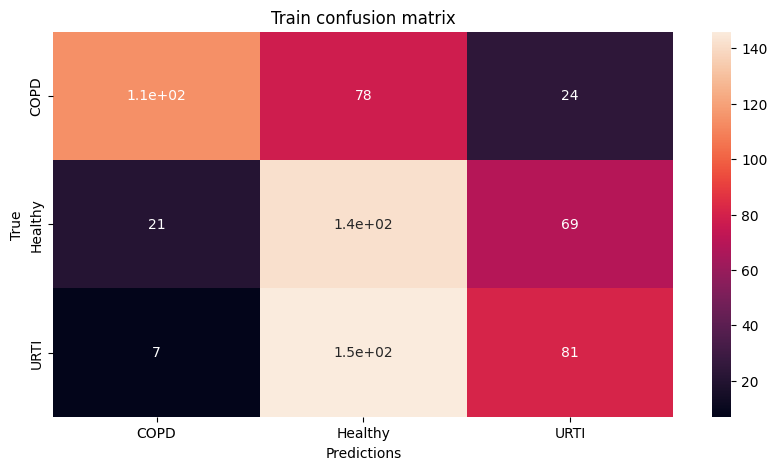

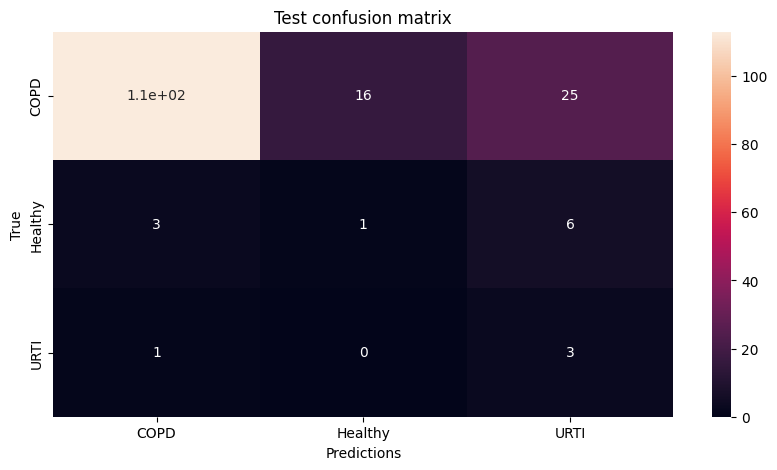


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.6019886363636364

Train Loss: 0.8669679815118964

Train F1 Score: 0.5760152434760873

Test Accuracy: 0.6510416666666666

Test Loss: 0.6721459825833639

Test F1 Score: 0.326559176047643




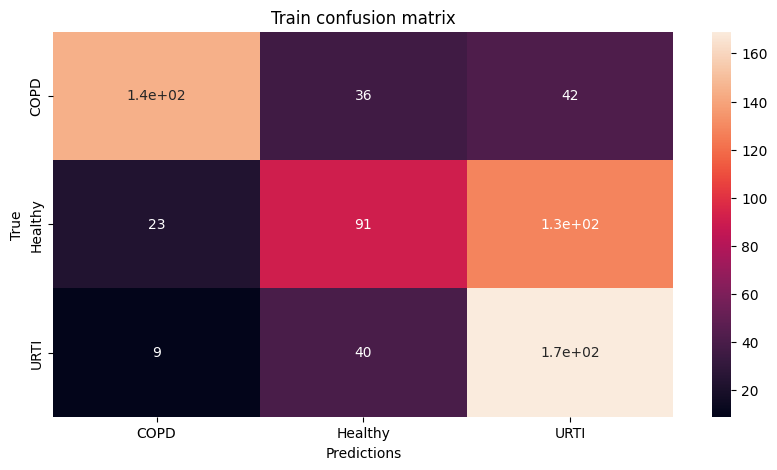

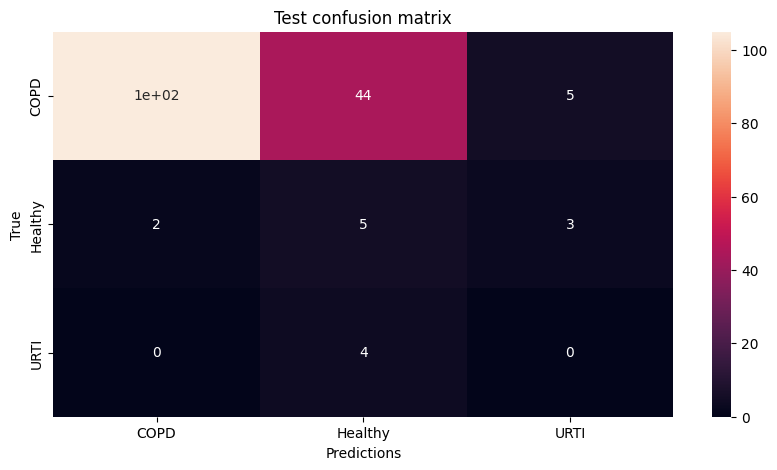


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.555965909090909

Train Loss: 0.8500830043445934

Train F1 Score: 0.5293722179802981

Test Accuracy: 0.5989583333333334

Test Loss: 0.7058960298697153

Test F1 Score: 0.2937520245711009




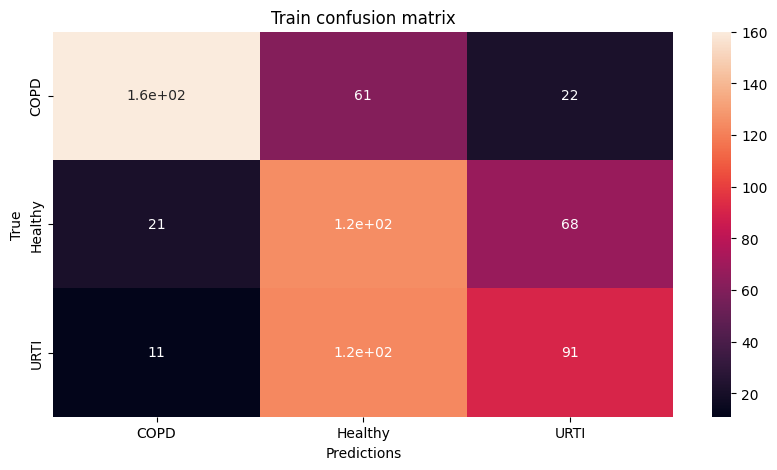

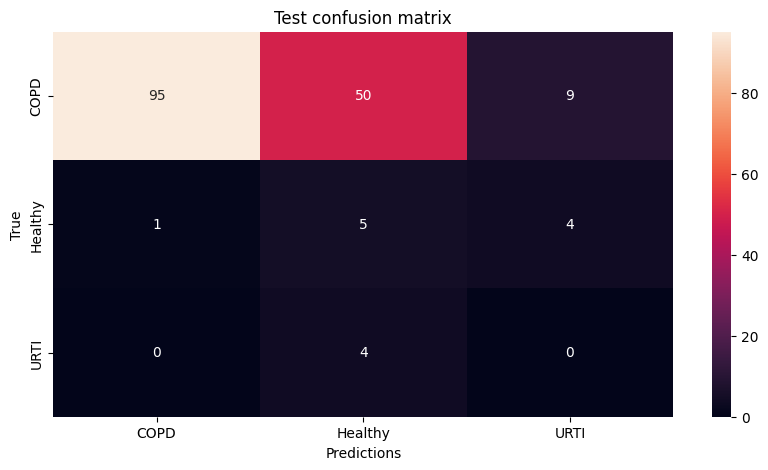


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.5167613636363636

Train Loss: 0.8758075426925312

Train F1 Score: 0.4890344603495164

Test Accuracy: 0.7395833333333334

Test Loss: 0.5908340563376745

Test F1 Score: 0.4963778108358383




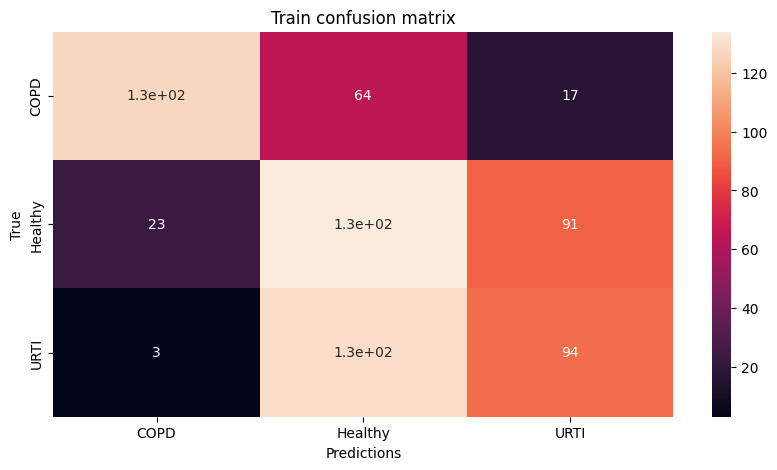

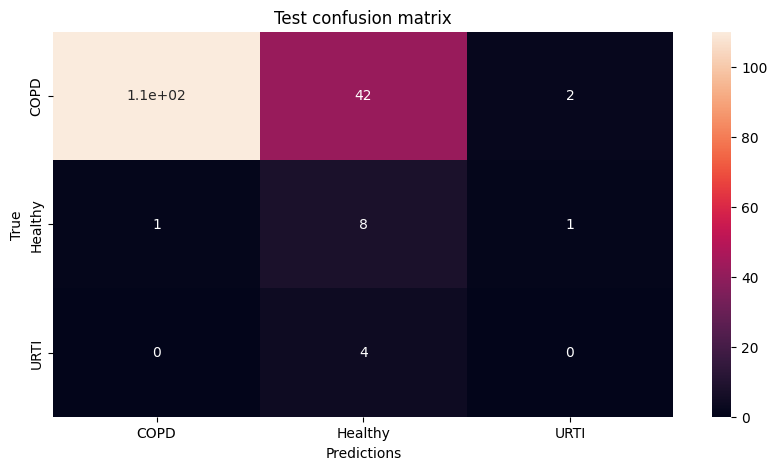


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.5383522727272727

Train Loss: 0.7970965152437036

Train F1 Score: 0.537851786071604

Test Accuracy: 0.6979166666666666

Test Loss: 0.7046886881192526

Test F1 Score: 0.3529968112707138




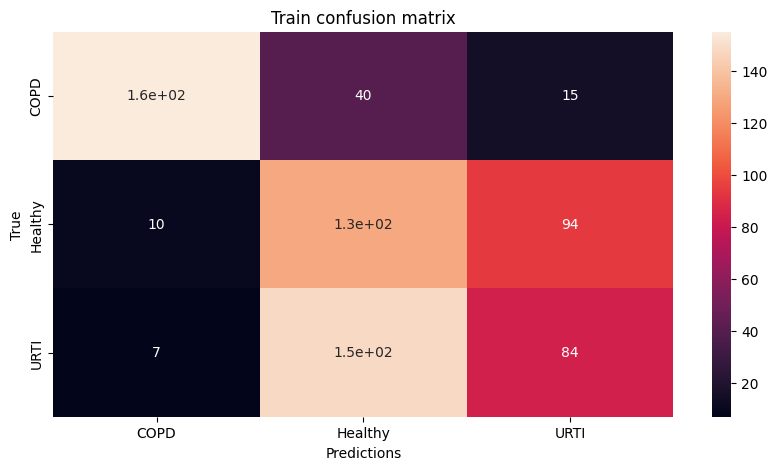

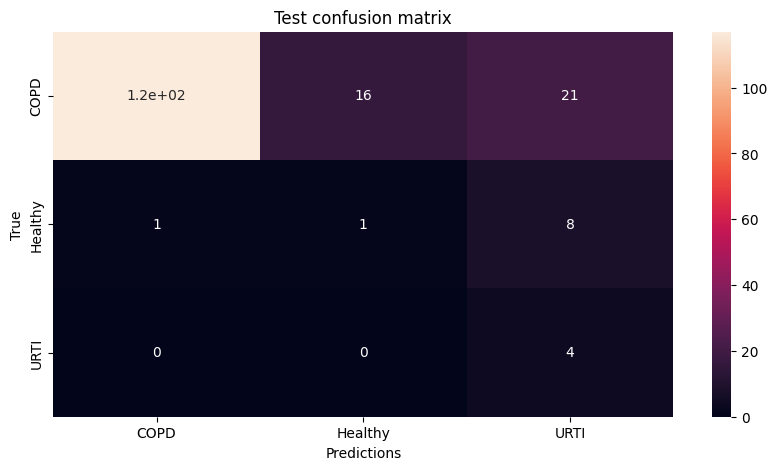


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.4852272727272728

Train Loss: 0.9378805404359644

Train F1 Score: 0.4512947310100902

Test Accuracy: 0.6302083333333334

Test Loss: 0.6208344995975494

Test F1 Score: 0.36500514050324756




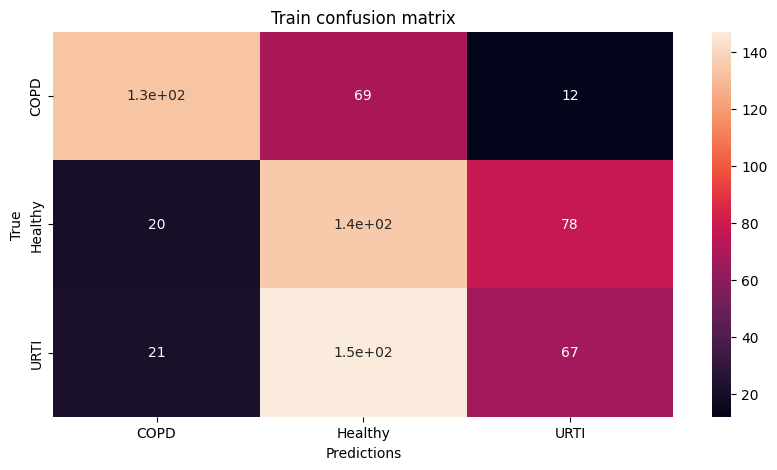

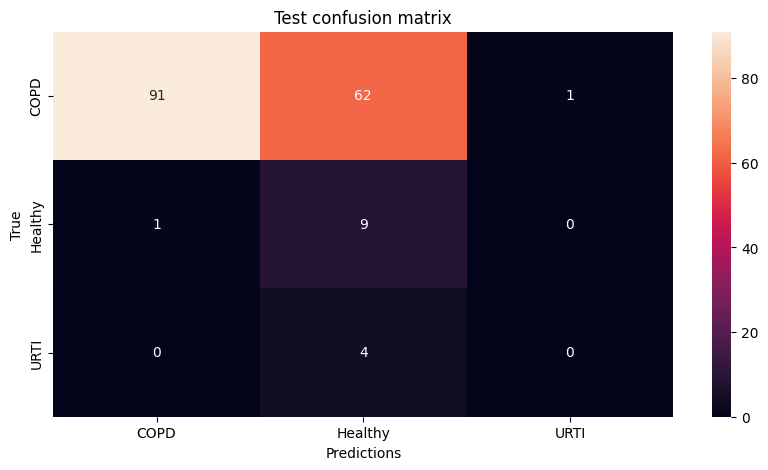


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.5522727272727272

Train Loss: 0.8297674005681818

Train F1 Score: 0.5348392128944397

Test Accuracy: 0.6458333333333334

Test Loss: 0.6240579336881638

Test F1 Score: 0.2958118865887324




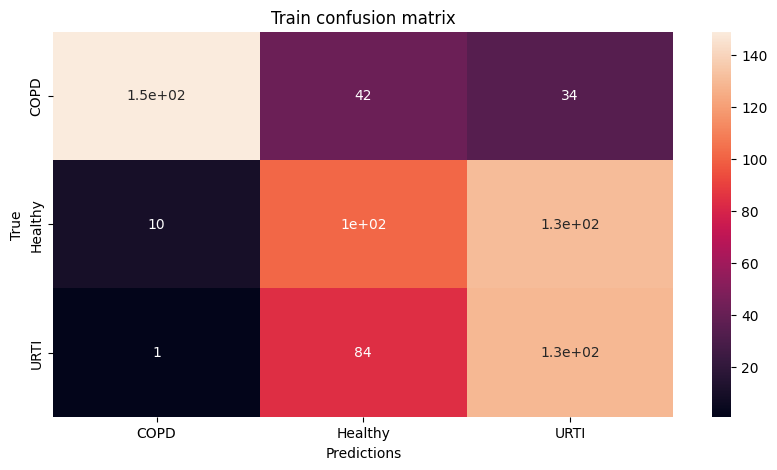

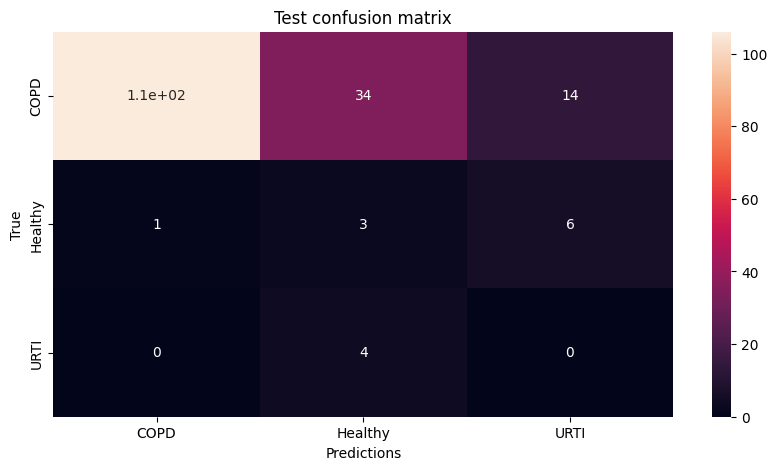


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.5329545454545455

Train Loss: 0.8180106417699293

Train F1 Score: 0.5328059196472168

Test Accuracy: 0.7447916666666666

Test Loss: 0.5243897289037704

Test F1 Score: 0.36917132635911304




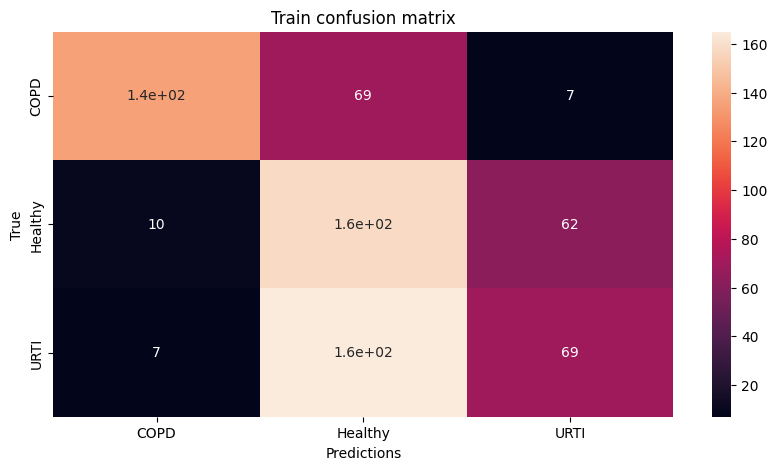

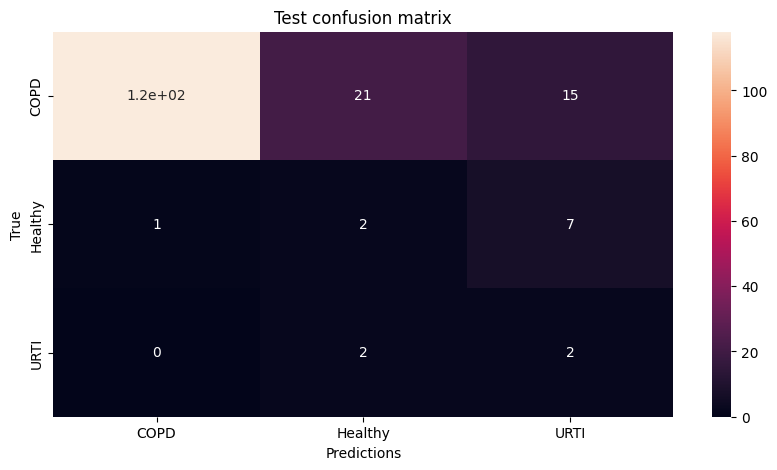


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.5911931818181818

Train Loss: 0.7841290100054308

Train F1 Score: 0.5820379650050943

Test Accuracy: 0.7760416666666666

Test Loss: 0.5454374849796295

Test F1 Score: 0.4574807683626811




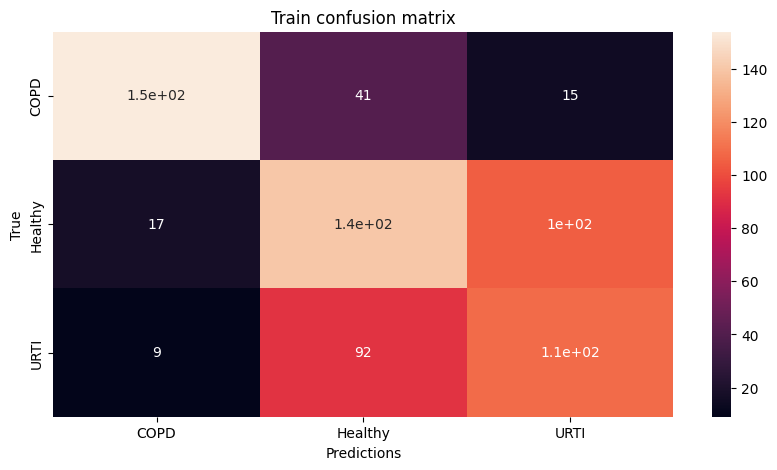

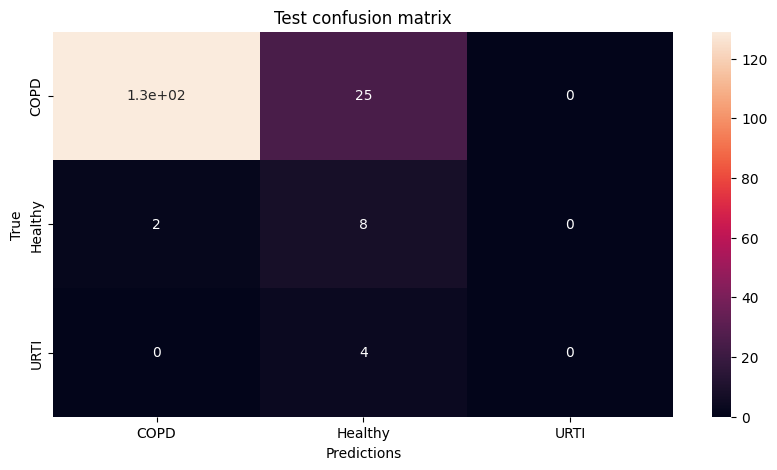


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.5710227272727273

Train Loss: 0.7631966038183733

Train F1 Score: 0.5360600988973271

Test Accuracy: 0.6875

Test Loss: 0.7431058784325918

Test F1 Score: 0.3194660320878029




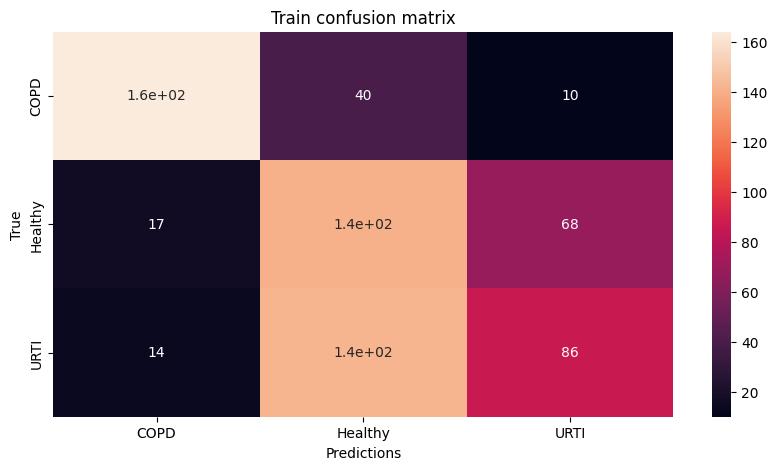

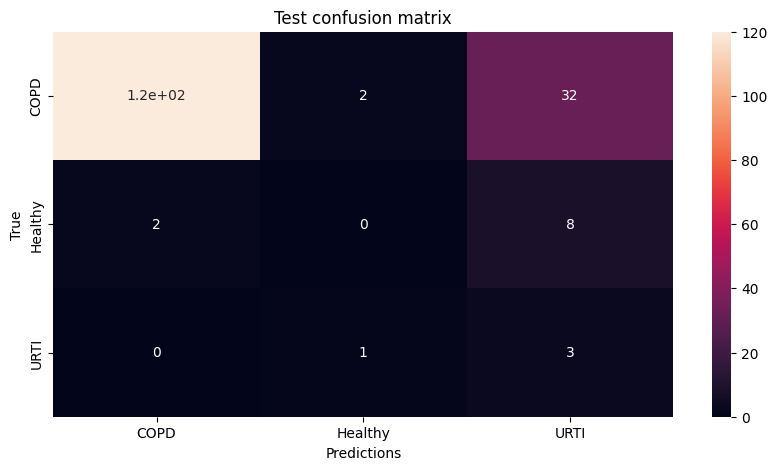


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.5982954545454545

Train Loss: 0.772931692275134

Train F1 Score: 0.5744092301888899

Test Accuracy: 0.75

Test Loss: 0.5843541274468104

Test F1 Score: 0.3999604781468709




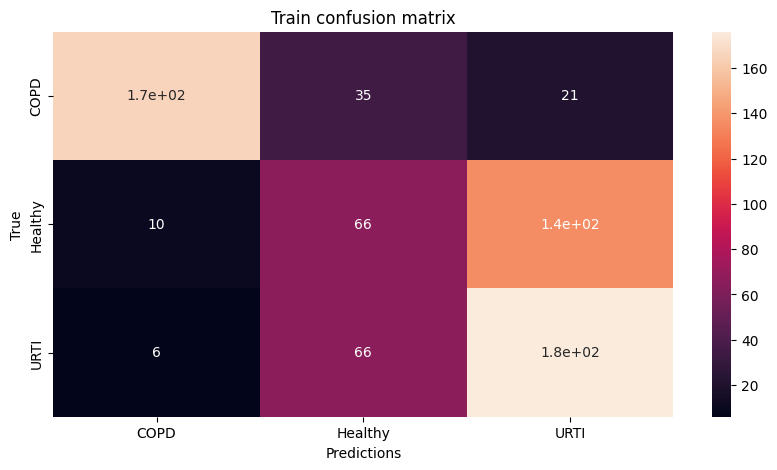

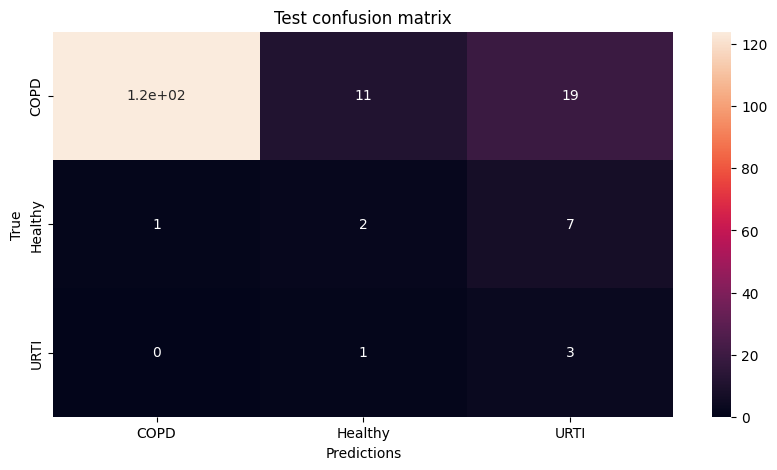


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.6150568181818182

Train Loss: 0.7223541303114458

Train F1 Score: 0.601781578226523

Test Accuracy: 0.7916666666666666

Test Loss: 0.5012950847546259

Test F1 Score: 0.45998721818129223




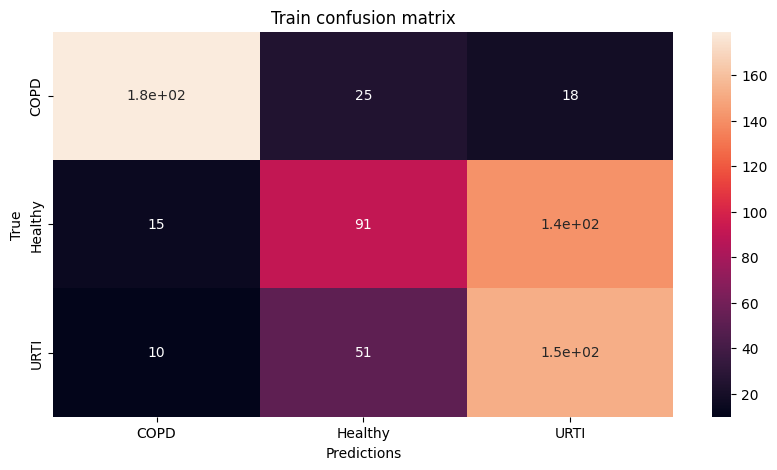

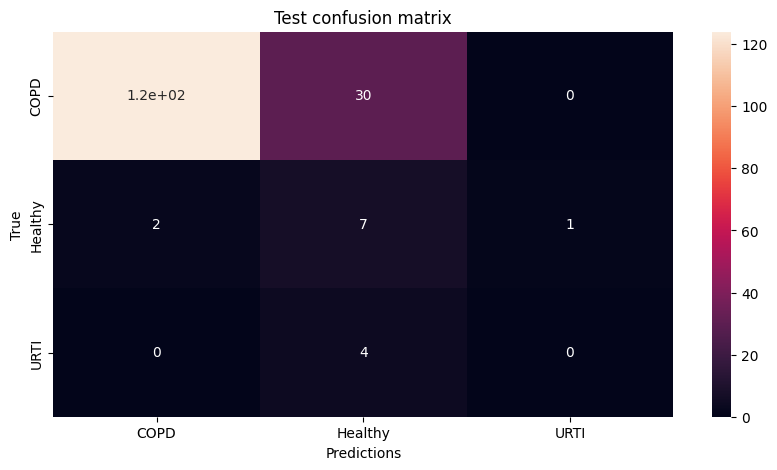


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.6088068181818183

Train Loss: 0.6966087438843467

Train F1 Score: 0.5543447502634742

Test Accuracy: 0.7239583333333334

Test Loss: 0.6353896260261536

Test F1 Score: 0.4668458551168442




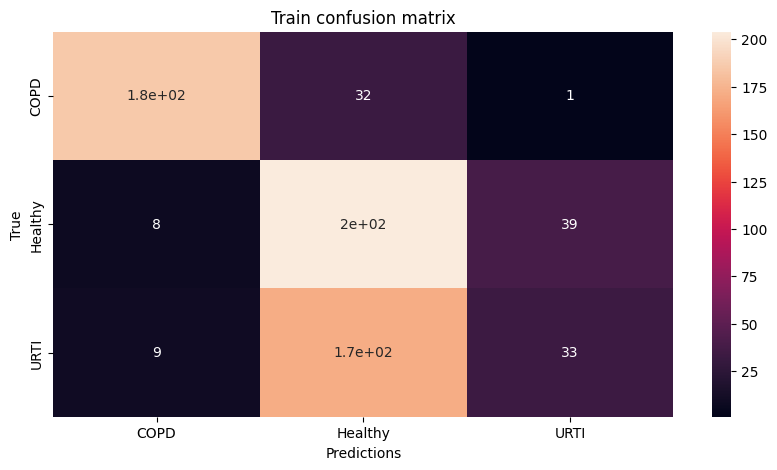

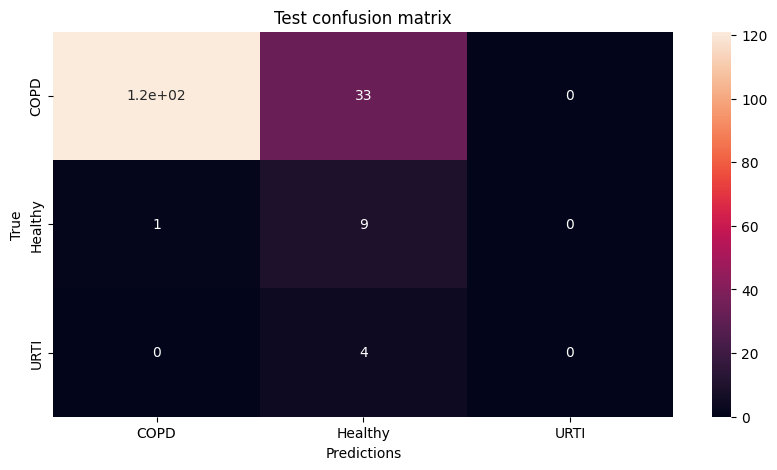


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.5599431818181818

Train Loss: 0.7891775505109266

Train F1 Score: 0.5159620154987682

Test Accuracy: 0.7552083333333334

Test Loss: 0.5195135672887167

Test F1 Score: 0.36194497843583423




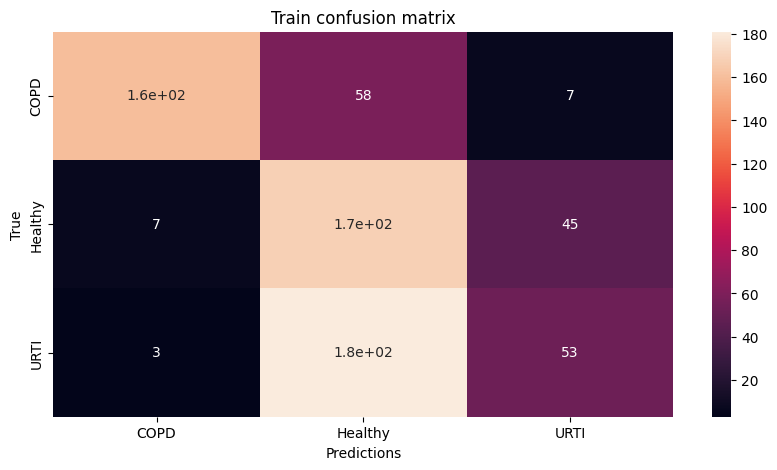

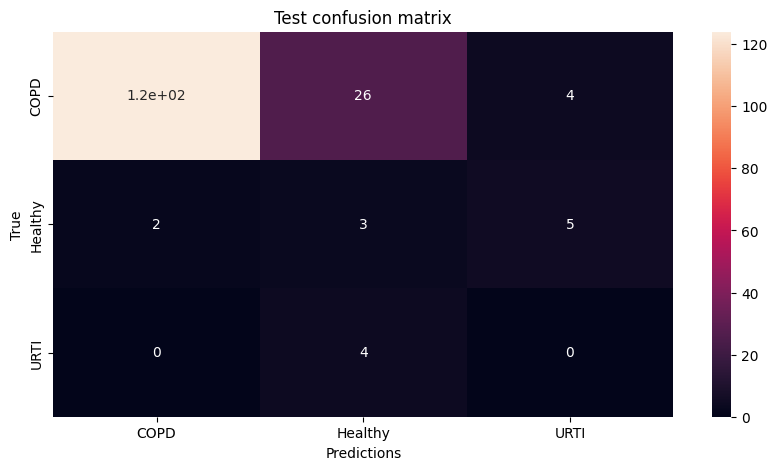


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.6247159090909091

Train Loss: 0.7147904634475708

Train F1 Score: 0.5937302288683978

Test Accuracy: 0.796875

Test Loss: 0.3557035873333613

Test F1 Score: 0.3236278643210729




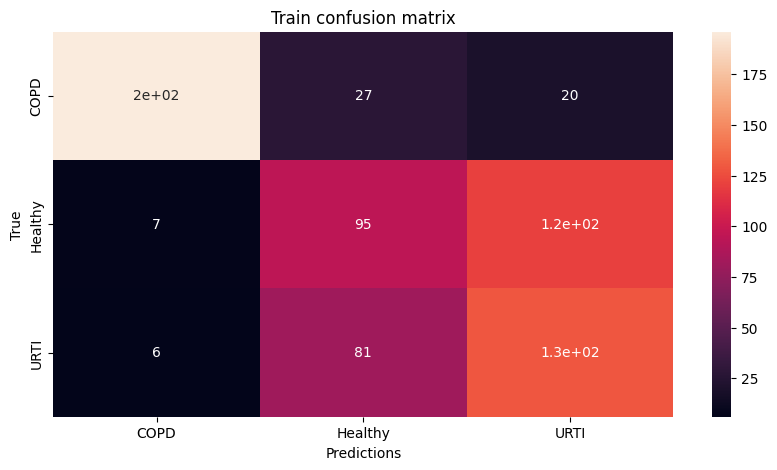

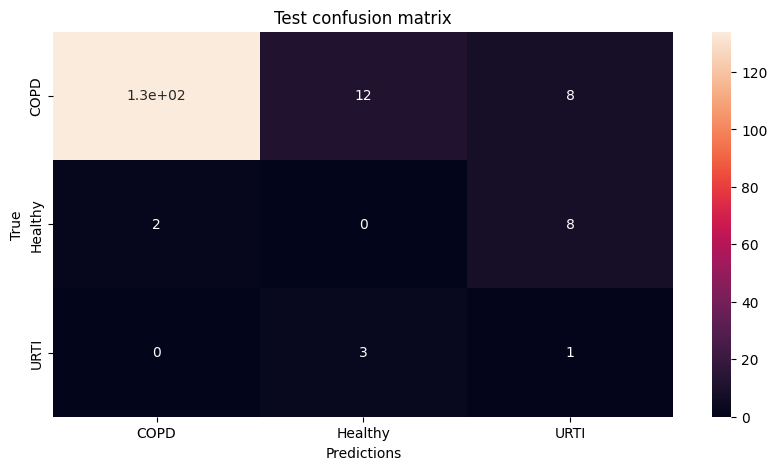


Training:


  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
epochs=100
train_model(model1,epochs)

### Training Model 2

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.19448088455772114

Train Loss: 1.7753370741139287

Train F1 Score: 0.159631481151218

Test Accuracy: 0.18297101449275363

Test Loss: 1.787315309047699

Test F1 Score: 0.05692580280204614




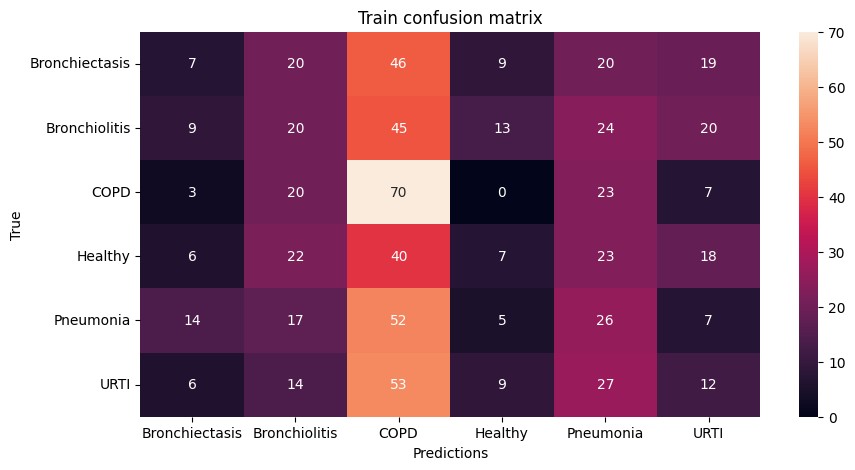

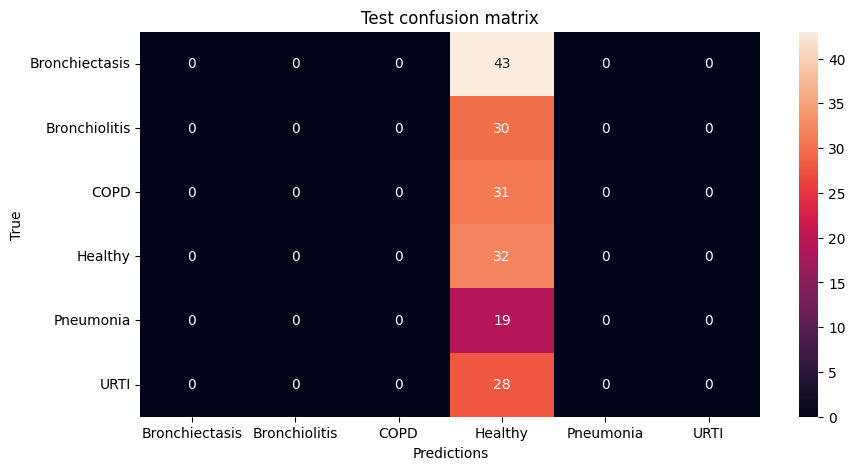


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.30467578710644677

Train Loss: 1.6197545683902244

Train F1 Score: 0.2633665890797325

Test Accuracy: 0.1872735507246377

Test Loss: 1.7177312175432842

Test F1 Score: 0.15716408751904964




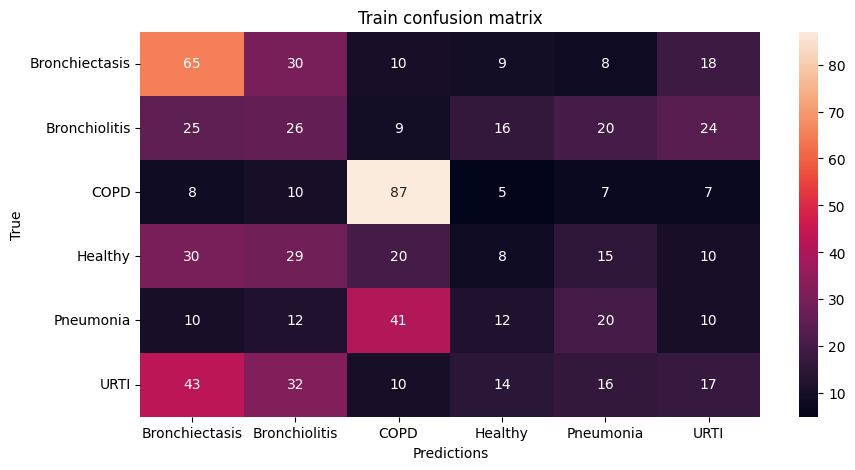

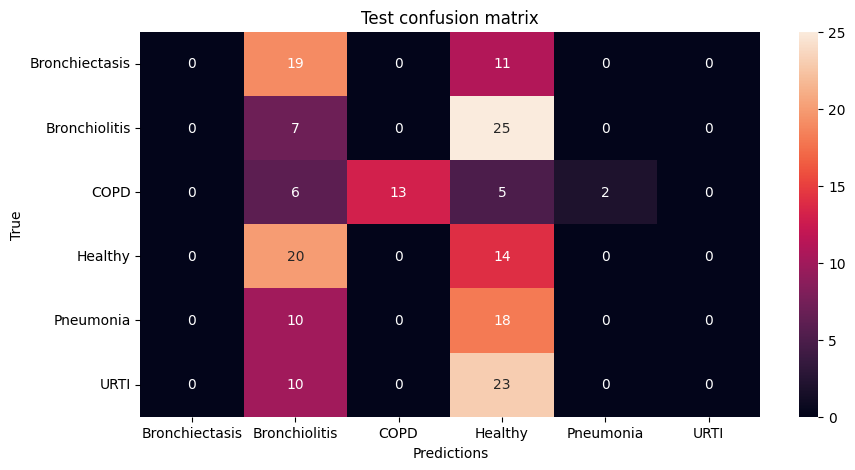


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.30247376311844076

Train Loss: 1.5830060554587322

Train F1 Score: 0.26537029639534326

Test Accuracy: 0.25905797101449274

Test Loss: 1.6750131249427795

Test F1 Score: 0.23115535577138266




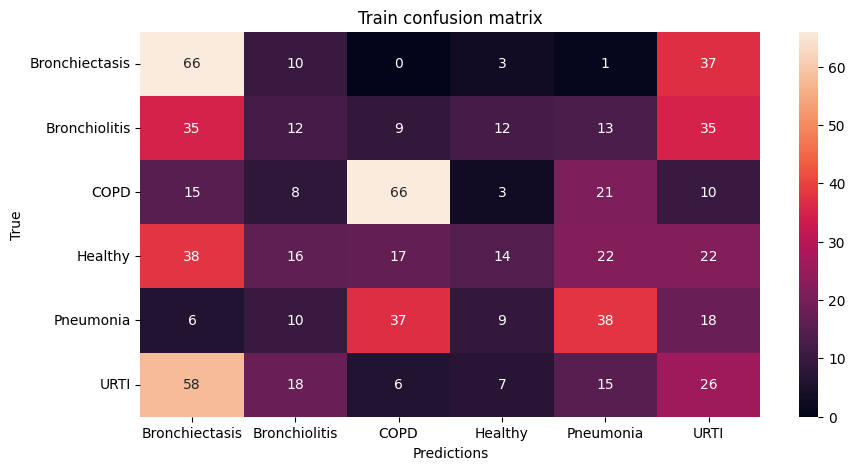

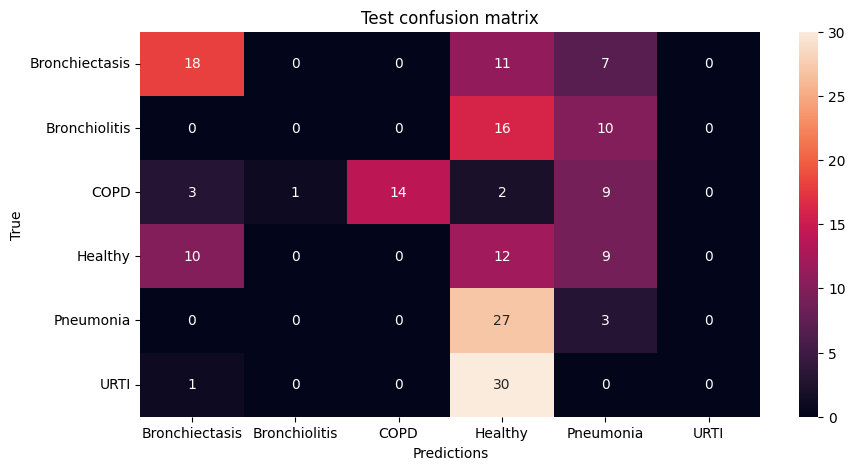


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.3807627436281859

Train Loss: 1.4763336026150247

Train F1 Score: 0.332021353037461

Test Accuracy: 0.27377717391304346

Test Loss: 1.6249796350797017

Test F1 Score: 0.23393704990545908




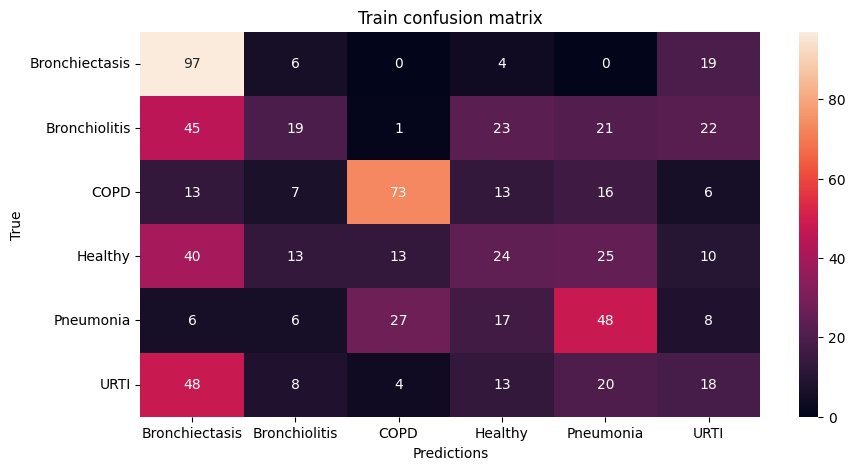

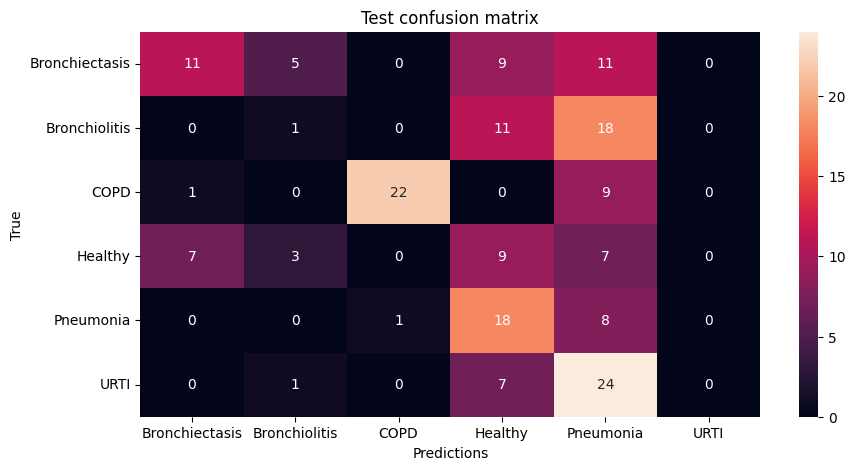


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.4132308845577211

Train Loss: 1.4359577946040942

Train F1 Score: 0.34271991123323853

Test Accuracy: 0.34125905797101447

Test Loss: 1.5578720172246296

Test F1 Score: 0.2701031838854154




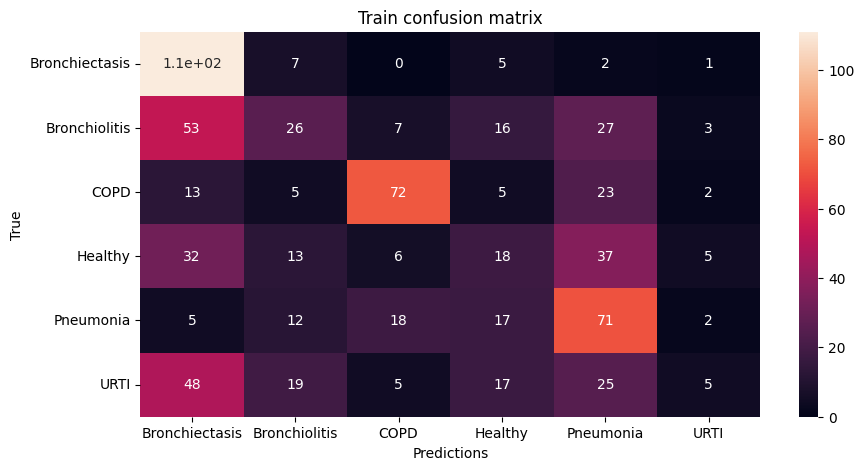

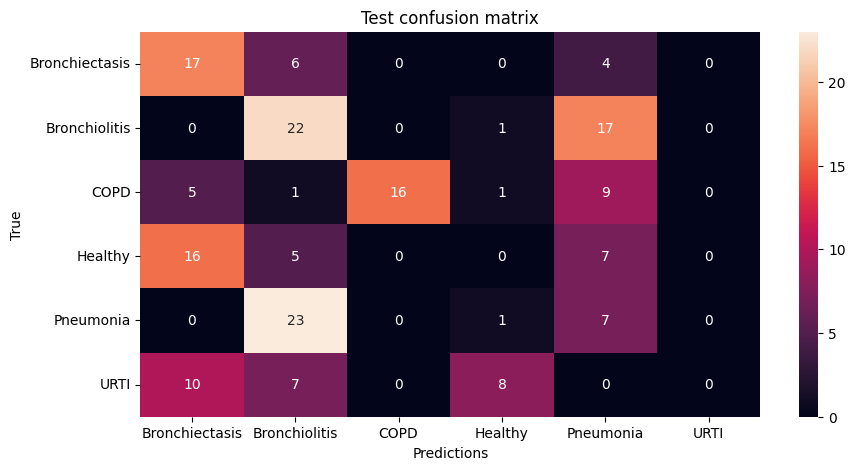


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.45197713643178405

Train Loss: 1.3621029180029165

Train F1 Score: 0.39821654428606446

Test Accuracy: 0.2946105072463768

Test Loss: 1.6489612460136414

Test F1 Score: 0.30406928062438965




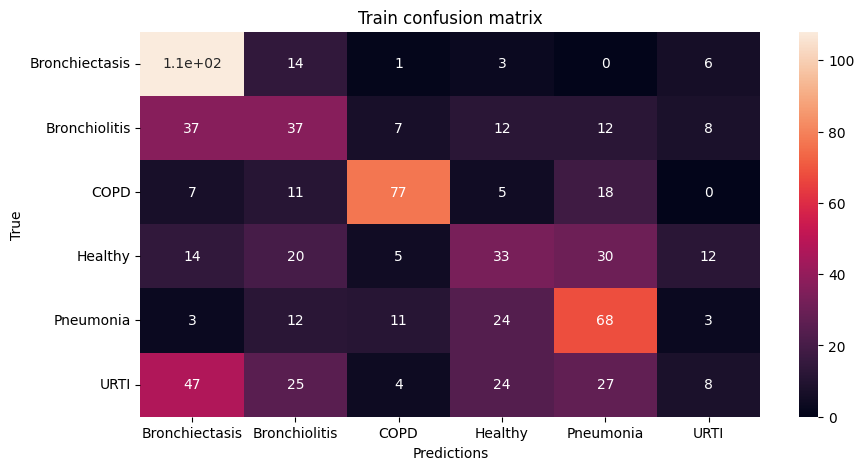

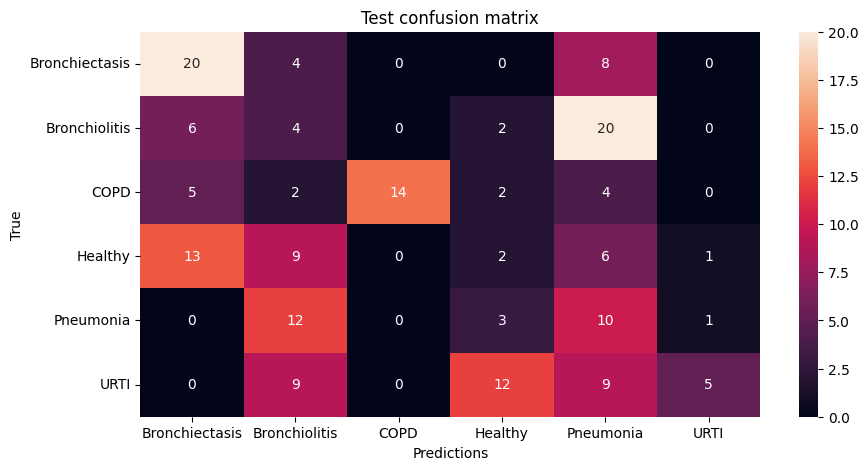


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.47929160419790107

Train Loss: 1.2989737417386926

Train F1 Score: 0.435052954632303

Test Accuracy: 0.40353260869565216

Test Loss: 1.5053910215695698

Test F1 Score: 0.37058240671952564




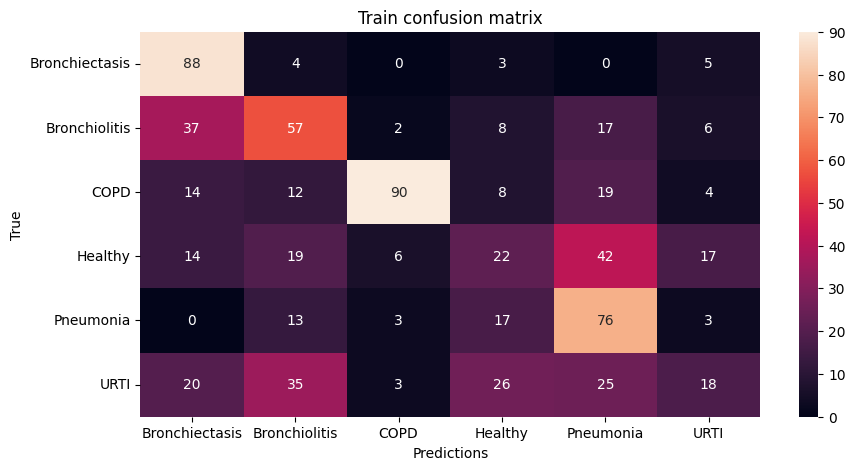

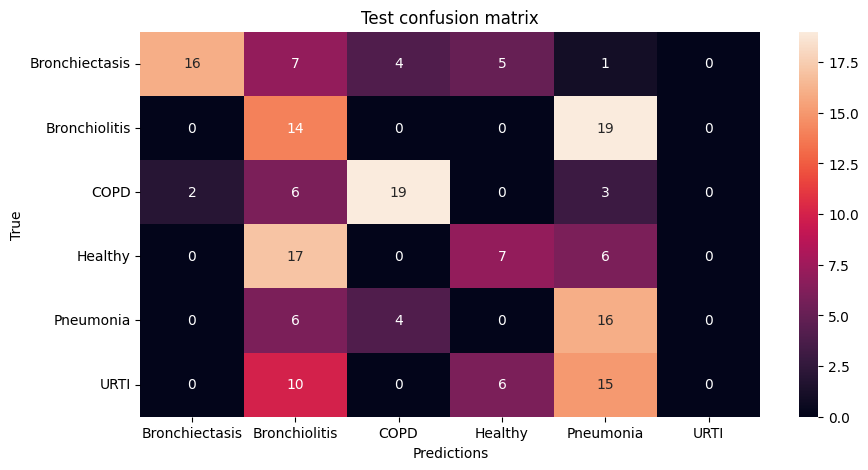


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.5476480509745127

Train Loss: 1.1677293129589246

Train F1 Score: 0.5128434598445892

Test Accuracy: 0.3580163043478261

Test Loss: 1.6136728922526042

Test F1 Score: 0.3448418478171031




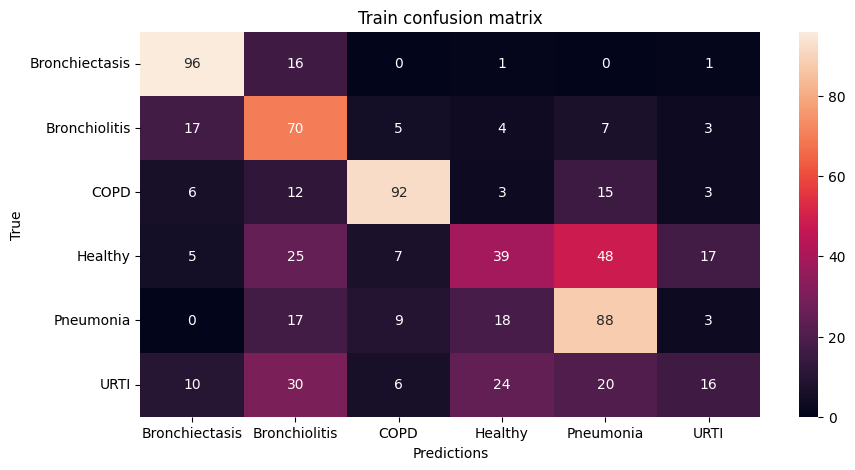

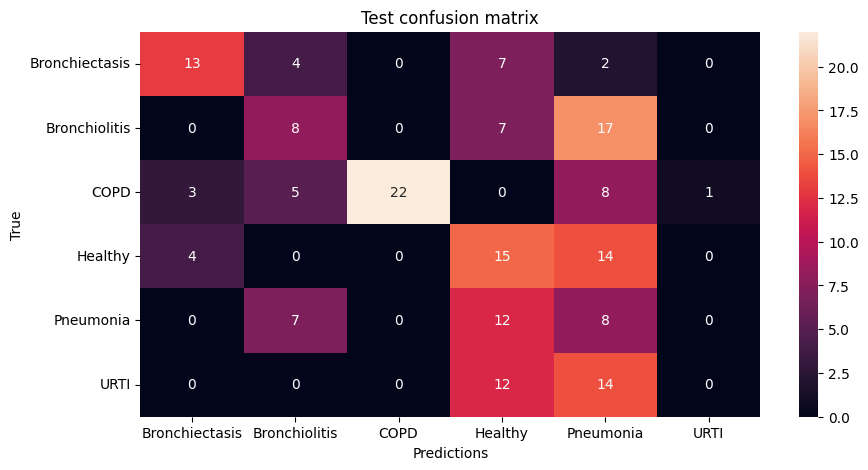


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.5803973013493253

Train Loss: 1.0911810709082561

Train F1 Score: 0.5286903018536775

Test Accuracy: 0.38292572463768115

Test Loss: 1.5099597374598186

Test F1 Score: 0.36519918342431384




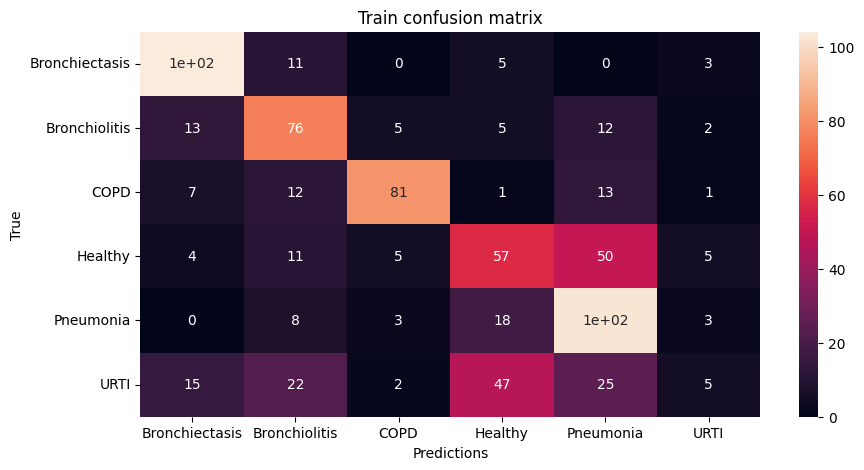

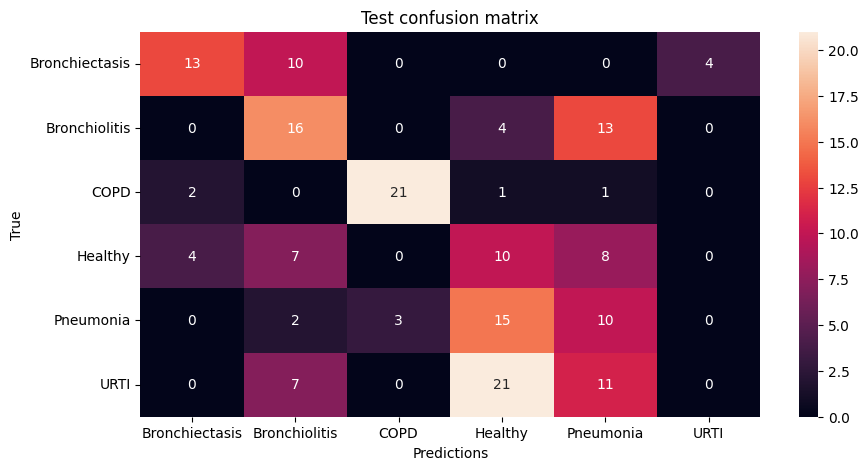


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.5851293103448275

Train Loss: 1.0167567315308943

Train F1 Score: 0.5606675251670505

Test Accuracy: 0.38088768115942023

Test Loss: 1.6746182640393574

Test F1 Score: 0.34315618872642517




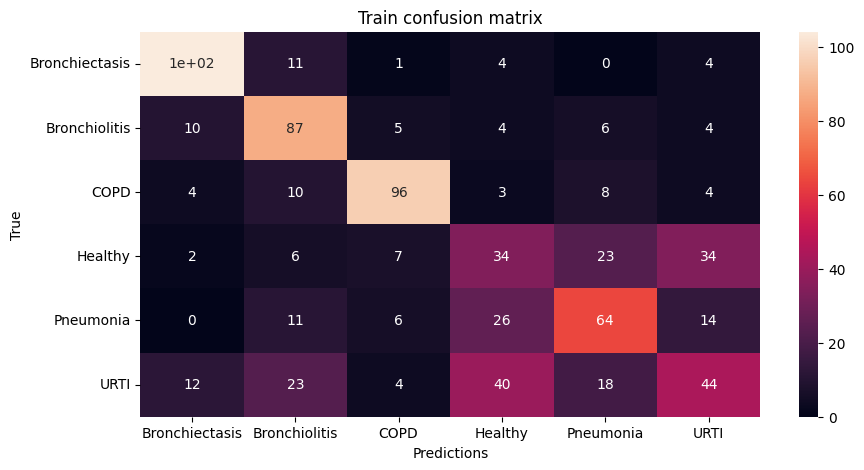

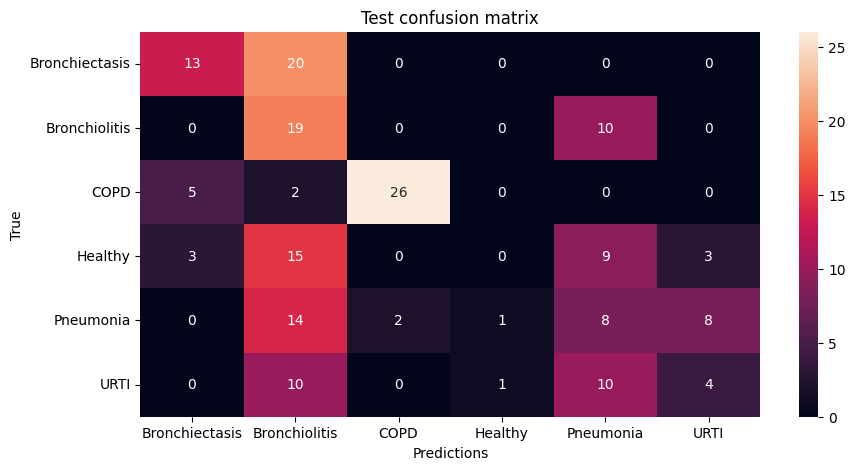


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.5927661169415293

Train Loss: 1.0069309524867847

Train F1 Score: 0.5715488052886465

Test Accuracy: 0.3267663043478261

Test Loss: 1.996050755182902

Test F1 Score: 0.3224567174911499




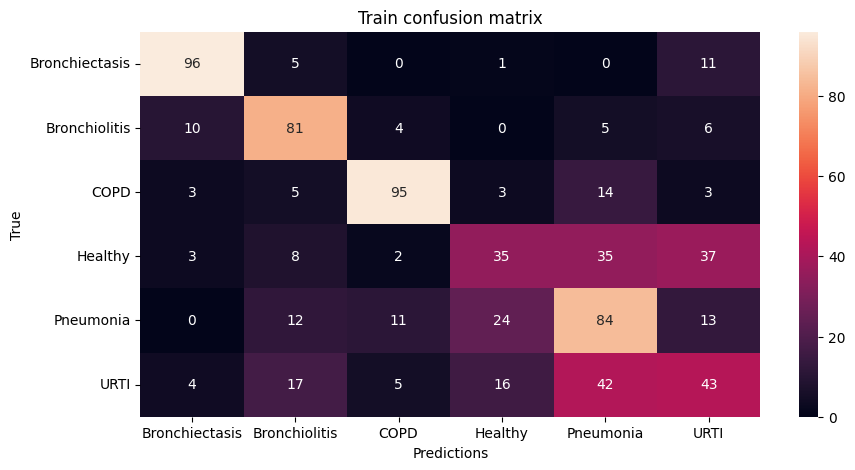

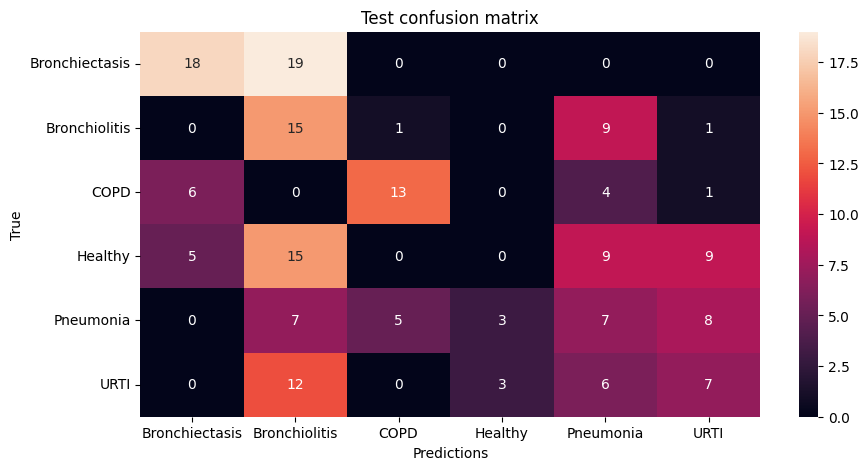


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.6343234632683659

Train Loss: 0.9048328295997952

Train F1 Score: 0.5971383348755215

Test Accuracy: 0.4900362318840579

Test Loss: 1.5409398476282756

Test F1 Score: 0.37546439965566




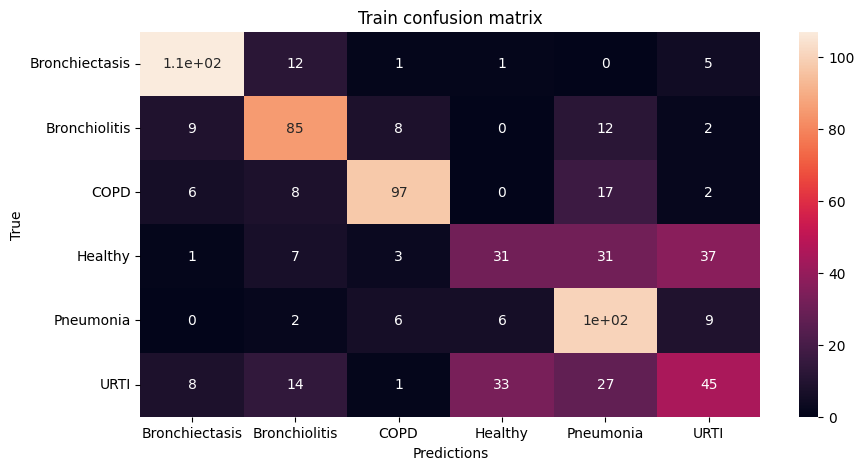

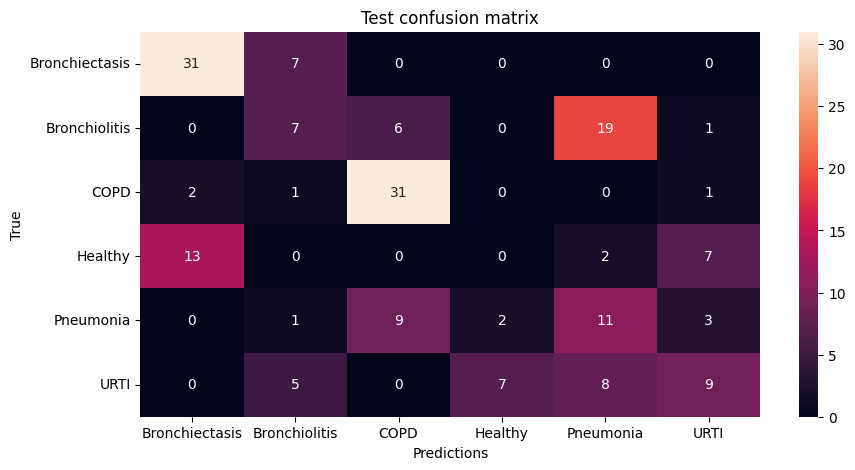


Training:


  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
epochs=100
train_model(model2,epochs)